In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import floor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [53]:
def hamming_distance(seq1, seq2):
    sum = 0
    for base1, base2 in zip(seq1, seq2):
        if base1 != base2:
            sum+=1
    return sum  

In [60]:
#TASK 1
#Calculate the pairwise Hamming distance matrix between sequences.
def pairwise_hamming_distance(seqs):
    distance_matrix = [[0 for _ in range(len(seqs))] for _ in range(len(seqs))]
    for i in range(len(seqs)):
        for j in range(i+1, len(seqs)):
            distance_matrix[i][j] = hamming_distance(seqs[i], seqs[j])
            distance_matrix[j][i] = distance_matrix[i][j]
    return distance_matrix

In [55]:
seqs = ["ACCGTTAGT","AACGTCGAT","AACGTCCAT","ACCGTTAAT","AACGTCAGT","ACCGTTAGG"]
distance_matrix = pairwise_hamming_distance(seqs)
distance_matrix

[[0, 4, 4, 1, 2, 1],
 [4, 0, 1, 3, 2, 5],
 [4, 1, 0, 3, 2, 5],
 [1, 3, 3, 0, 3, 2],
 [2, 2, 2, 3, 0, 3],
 [1, 5, 5, 2, 3, 0]]

In [56]:
def create_matrix(seqs,distance_matrix):
    from Bio.Phylo.TreeConstruction import _Matrix
    distance_matrix_lower=[]
    for i in range(0,len(distance_matrix)):
        dist=[]
        for j in range(0,i+1):
            dist.append(distance_matrix[i][j])
        distance_matrix_lower.append(dist)
        
    m = _Matrix(seqs,distance_matrix_lower)
    m.sequence = seqs
    return m

In [57]:
m = create_matrix(seqs,distance_matrix)
m.sequence

['ACCGTTAGT', 'AACGTCGAT', 'AACGTCCAT', 'ACCGTTAAT', 'AACGTCAGT', 'ACCGTTAGG']

In [58]:
#TASK 2
#Build a rooted phylogenetic tree
from Bio.Phylo.TreeConstruction import DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import Phylo

def build_tree(distance_matrix, method, outgroup=None):
   # Convert the distance matrix to a Bio.Phylo DistanceMatrix object
    dm = DistanceMatrix(names=distance_matrix.names, matrix=distance_matrix.matrix)

    # Construct the tree using the Neighbor Joining algorithm
    constructor = DistanceTreeConstructor()
    if method == 'upgma':
        tree = constructor.upgma(dm)
    elif method == 'nj':
        tree = constructor.nj(dm)
        #Choose a root for the tree
        tree.root_with_outgroup({'name': outgroup})

    return tree

In [59]:
tree_upgma=build_tree(m,'upgma')
tree_upgma.ladderize()
Phylo.draw(tree_upgma,branch_labels=lambda branch: round((branch.branch_length), 2))

MissingPythonDependencyError: Install matplotlib or pylab if you want to use draw.

In [ ]:
Phylo.draw_ascii(tree_upgma,)

                           _________________________________________ AACGTCAGT
  ________________________|
 |                        |                     ____________________ AACGTCCAT
 |                        |____________________|
_|                                             |____________________ AACGTCGAT
 |
 |                                    ______________________________ ACCGTTAAT
 |___________________________________|
                                     |          ____________________ ACCGTTAGG
                                     |_________|
                                               |____________________ ACCGTTAGT



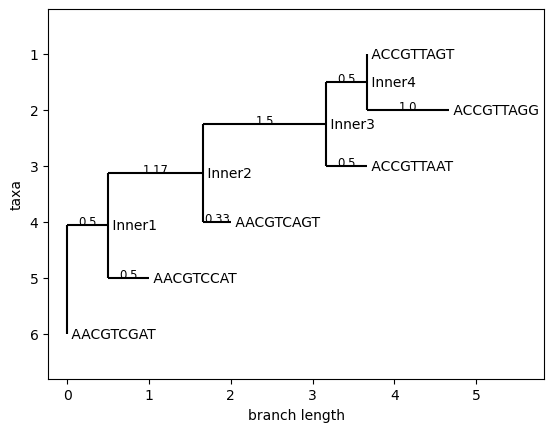

In [ ]:
tree_nj=build_tree(m,'nj',"AACGTCGAT")
Phylo.draw(tree_nj,branch_labels=lambda branch: round((branch.branch_length), 2))

In [ ]:
#TASK 3
# Infer the ancestral sequences in a phylogenetic tree using the small parsimony algorithm.
def small_parsimony(tree):
    # Initialize the score and sequence for each node
    for node in tree.find_clades(order='postorder'):
        node.score = []
        if node.is_terminal():
            for idx in range(9):
                node.score.append({base: 0 if base == node.name[idx] else float('inf') for base in ['A', 'C', 'G', 'T']})
        
        else:
            for idx in range(9):
                node.score.append({base: float('inf') for base in ['A', 'C', 'G', 'T']})
            
            
            for child in node.clades:
                total_score = []
                for idx in range(9):
                    child_score = {}
                    for base in ['A', 'C', 'G', 'T']:
                        temp=[]
                        for b in ['A', 'C', 'G', 'T']:
                            temp.append((child.score[idx][b]) + (0 if b == base else 1))
                        child_score.update({base:min(temp)})
                    total_score.append(child_score)
                    for b in ['A', 'C', 'G', 'T']:
                        if total_score[idx][b] < node.score[idx][b]:
                            node.score[idx][b] = total_score[idx][b]
                            print(child_score)
                            
    for node in tree.find_clades(order='postorder'):            
        name = ''
        if not node.is_terminal():
            for idx in range(9):
                for base in ['A', 'C', 'G', 'T']:
                    if node.score[idx][base] == min(node.score[idx].values()):
                        name += base 
                        
            print(node.name+": "+name)
            node.name=name

    return tree

In [ ]:
tree1=small_parsimony(tree_upgma)

Inner2: AACGTCGAT
Inner4: AACGTCGAT
Inner1: ACCGTTAGT
Inner3: ACCGTTAGT
Inner5: ACCGTTAGT
AACGTCAGT [{'A': 0, 'C': inf, 'G': inf, 'T': inf}, {'A': 0, 'C': inf, 'G': inf, 'T': inf}, {'A': inf, 'C': 0, 'G': inf, 'T': inf}, {'A': inf, 'C': inf, 'G': 0, 'T': inf}, {'A': inf, 'C': inf, 'G': inf, 'T': 0}, {'A': inf, 'C': 0, 'G': inf, 'T': inf}, {'A': 0, 'C': inf, 'G': inf, 'T': inf}, {'A': inf, 'C': inf, 'G': 0, 'T': inf}, {'A': inf, 'C': inf, 'G': inf, 'T': 0}]
AACGTCCAT [{'A': 0, 'C': inf, 'G': inf, 'T': inf}, {'A': 0, 'C': inf, 'G': inf, 'T': inf}, {'A': inf, 'C': 0, 'G': inf, 'T': inf}, {'A': inf, 'C': inf, 'G': 0, 'T': inf}, {'A': inf, 'C': inf, 'G': inf, 'T': 0}, {'A': inf, 'C': 0, 'G': inf, 'T': inf}, {'A': inf, 'C': 0, 'G': inf, 'T': inf}, {'A': 0, 'C': inf, 'G': inf, 'T': inf}, {'A': inf, 'C': inf, 'G': inf, 'T': 0}]
AACGTCGAT [{'A': 0, 'C': inf, 'G': inf, 'T': inf}, {'A': 0, 'C': inf, 'G': inf, 'T': inf}, {'A': inf, 'C': 0, 'G': inf, 'T': inf}, {'A': inf, 'C': inf, 'G': 0, 'T': inf

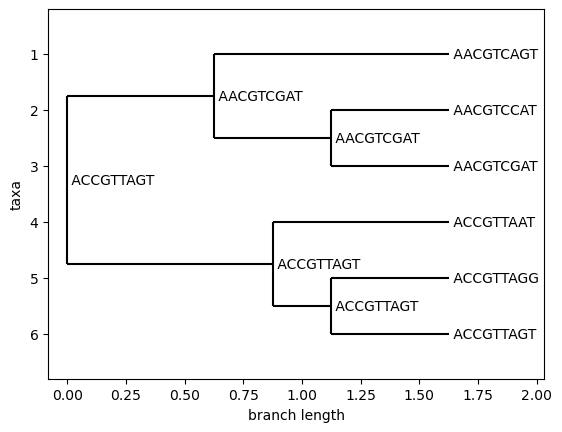

In [ ]:
Phylo.draw(tree1)

In [ ]:
virus_names = ['SARS-CoV-2','MERS-CoV','Bat-CoV','SARS-CoV','Pangolin-CoV']
with open('sars_cov_2.txt') as f:
    sars2 = f.read()
with open('mers.txt') as f:
    mers = f.read()
with open('bat_cov.txt') as f:
    bat = f.read()
with open('sars.txt') as f:
    sars = f.read()
with open('pangolin_cov.txt') as f:
    pang = f.read()
    
virus_seqs = [sars2,mers,bat,sars,pang]

In [ ]:
#TASK 4
#BetterFrequentWords() function
def BetterFrequentWords(text, k):
    freqPatterns = []
    freqMap = FrequencyMap(text, k)
    maxCount = max(freqMap.values())
    for pattern, count in freqMap.items():
        if count == maxCount:
            freqPatterns.append(pattern)
    return freqPatterns[0]

def FrequencyMap(text, k):
    freqMap = {}
    n = len(text)
    for i in range(n - k + 1):
        pattern = text[i:i+k]
        if pattern not in freqMap:
            freqMap[pattern] = 1
        else:
            freqMap[pattern] += 1
    return freqMap

In [ ]:
freq_9mers = []
for seq in virus_seqs:
    freq_9mers.append(BetterFrequentWords(seq, 9))

freq_9mers

['TAAACGAAC', 'TTAACGAAC', 'TAAACGAAC', 'TAAACGAAC', 'TAATGGTAA']

In [ ]:
distance_matrix = pairwise_hamming_distance(freq_9mers)
distance_matrix

[[0, 1, 0, 0, 4],
 [1, 0, 1, 1, 5],
 [0, 1, 0, 0, 4],
 [0, 1, 0, 0, 4],
 [4, 5, 4, 4, 0]]

In [ ]:
from Bio.Phylo.TreeConstruction import _Matrix

distance_matrix_lower=[]
for i in range(0,len(distance_matrix)):
    dist=[]
    for j in range(0,i+1):
        dist.append(distance_matrix[i][j])
    distance_matrix_lower.append(dist)
    

m = _Matrix(virus_names,distance_matrix_lower)
m

_Matrix(names=['SARS-CoV-2', 'MERS-CoV', 'Bat-CoV', 'SARS-CoV', 'Pangolin-CoV'], matrix=[[0], [1, 0], [0, 1, 0], [0, 1, 0, 0], [4, 5, 4, 4, 0]])

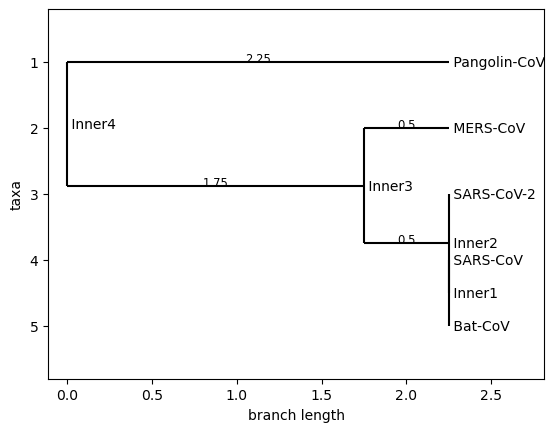

In [ ]:
tree_upgma=build_tree(m,'upgma')
tree_upgma.ladderize()
Phylo.draw(tree_upgma,branch_labels=lambda branch: round((branch.branch_length), 2))

In [ ]:
Phylo.draw_ascii(tree_upgma,)

  _______________________________________________________________ Pangolin-CoV
_|
 |                                                 ______________ MERS-CoV
 |________________________________________________|
                                                  |              , SARS-CoV-2
                                                  |______________|
                                                                 , SARS-CoV
                                                                 |
                                                                 | Bat-CoV



In [63]:
from Bio import Phylo, AlignIO
import subprocess
import matplotlib
import matplotlib.pyplot as plt
from Bio.Phylo import draw

plt.rc('font', size=10)          # controls default text sizes #HERE IS THE SETTING FOR THAT ALLOWS ME TO HIDE THE BRANCH TIP LABELS
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=18)   # fontsize of the figure title

draw(tree_upgma, do_show=False,branch_labels=lambda branch: round((branch.branch_length), 2))
plt.savefig("TreeToCutOff.svg", format='svg', dpi=1200)

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
print(tree_upgma)

Tree(rooted=True)
    Clade(branch_length=0, name='Inner4')
        Clade(branch_length=2.25, name='Pangolin-CoV')
        Clade(branch_length=1.75, name='Inner3')
            Clade(branch_length=0.5, name='MERS-CoV')
            Clade(branch_length=0.5, name='Inner2')
                Clade(branch_length=0.0, name='SARS-CoV-2')
                Clade(branch_length=0.0, name='Inner1')
                    Clade(branch_length=0.0, name='SARS-CoV')
                    Clade(branch_length=0.0, name='Bat-CoV')


In [ ]:
virus_names2 = ['HIV', 'Adeno', 'Ebola', 'HepatitisB']
with open('hiv.txt') as f:
    hiv = f.read()
with open('adeno.txt') as f:
    adeno = f.read()
with open('ebola.txt') as f:
    ebola = f.read()
with open('hepB.txt') as f:
    hepB = f.read()

virus_seqs2 = [hiv,adeno,ebola,hepB]

In [ ]:
freq_9mers2 = []
for seq in virus_seqs2:
    freq_9mers2.append(BetterFrequentWords(seq, 9))

#freq_9mers2_use = [freq_9mers2[0][2],freq_9mers2[1][0],freq_9mers2[2][1],freq_9mers2[3][6]]
freq_9mers2_use = freq_9mers2
freq_9mers2_use

['AAAGAAAAA', 'GGCGGCGGC', 'GAAGATTAA', 'TTCTTGTTG']

In [ ]:
distance_matrix2 = pairwise_hamming_distance(freq_9mers2_use)
distance_matrix2

[[0, 8, 3, 9], [8, 0, 7, 8], [3, 7, 0, 8], [9, 8, 8, 0]]

In [ ]:
m2 = create_matrix(freq_9mers2_use,distance_matrix2)
m2.sequence = freq_9mers2_use
m2.sequence, m2.names, m2.matrix

(['AAAGAAAAA', 'GGCGGCGGC', 'GAAGATTAA', 'TTCTTGTTG'],
 ['AAAGAAAAA', 'GGCGGCGGC', 'GAAGATTAA', 'TTCTTGTTG'],
 [[0], [8, 0], [3, 7, 0], [9, 8, 8, 0]])

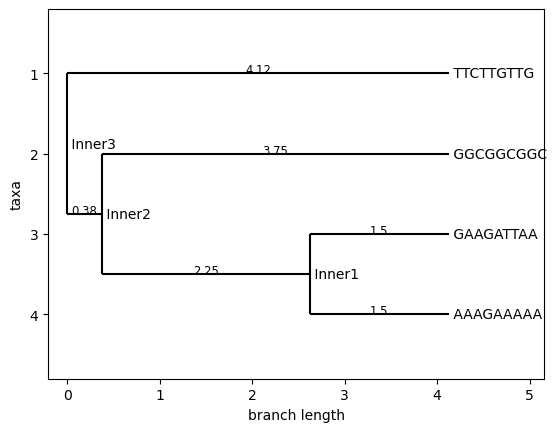

In [ ]:
tree_upgma2=build_tree(m2,'upgma')
tree_upgma2.ladderize()
Phylo.draw(tree_upgma2,branch_labels=lambda branch: round((branch.branch_length), 2))

Inner1: AAAGAAAAA
Inner2: AAAGAAAAA
Inner3: AAAGAAAAA


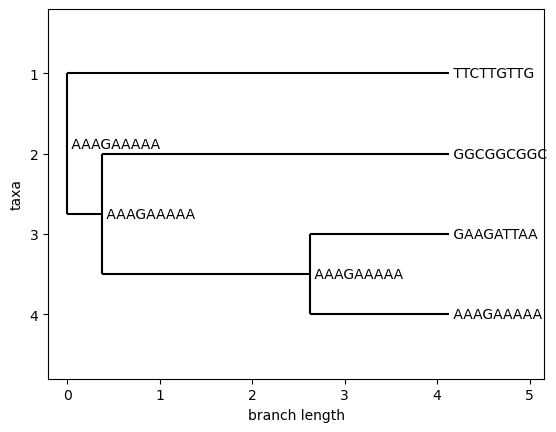

In [ ]:
tree3=small_parsimony(tree_upgma2)
Phylo.draw(tree3)